# Mandelbrot Set
The Mandelbrot set is the set of complex numbers $c$ for which the absolute value of the sequence $z_n$ remains bounded for all $n > 0$, where $z_n$ is:
$$
\begin{align}
z_0 &= 0, \\
z_{n+1} &= z_n^2 + c.
\end{align}
$$
For any complex number $c$, one of two things will happen:
- The sequence blows up to infinity ($|z_n| \gt 2$)
- The sequence if bounded ($|z_n| \le 2$)

Then, $c$ belongs to the Mandelbrot set $M$ if the second case ($|z_n| \le 2$) holds:
$$
M = \{c \in \mathbb{C} \mid \lvert z_n \rvert \le 2 \}.
$$

In [18]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import queue
import shelve
import time
from statistics import NormalDist

# plot settings
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11
#plt.rc("text", usetex=True)
#plt.rc("text.latex", preamble=r"""
# \usepackage{palatino}
# \usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [2]:
from cpp_stoch import (
    f_c as f_c_cpp,
    mandelbrot_grid,
    set_num_threads,
    get_num_threads
)

from Function import Monte_carlo, I_iter_worker, S_iter_worker, \
  uniform_sampler, latin_square_sampler

In [3]:
# RNG initialization for parallel sampling
#  see https://albertcthomas.github.io/good-practices-random-number-generators/
#  and https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html#numpy.random.MT19937
from numpy.random import Generator, MT19937, SeedSequence

def initialize_parallel_rngs(n, seed):
    sg = SeedSequence(seed)
    bit_generator = MT19937(sg)
    rngs = []
    for _ in range(n):
        rngs.append(Generator(bit_generator))
        bit_generator = bit_generator.jumped()
        
    return rngs

In [7]:
def Confidence_intervals(Samples, p = 0.95):
    Lambda = NormalDist().inv_cdf((p + 1)/2)
    S2 = np.var(Samples, ddof = 1)
    S = np.sqrt(S2)
    a = (Lambda*S)/np.sqrt(len(Samples))
    return a    

In [4]:
def S_iter(max_iter, n_runs, S_min_exp, S_max_exp, sampling_method = uniform_sampler):
    manager = mp.Manager()

    Approx_areas_list = manager.list()  
    sample_size_range = np.logspace(S_min_exp, S_max_exp, num = ((S_max_exp - S_min_exp) + 1)*4, dtype = int)

    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for sample_size in sample_size_range:
            work_queue.put((sample_size, i))


    rngs = initialize_parallel_rngs(mp.cpu_count(), 273583)
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=S_iter_worker, args=(
            work_queue, Approx_areas_list, max_iter, rngs[i], sampling_method
        ))
        p.daemon = True
        p.start()
        processes.append(p)


    for p in processes:
        p.join()


    return [list(v) for v in Approx_areas_list], sample_size_range        

In [30]:
def I_iter(sample_size, n_runs, I_min_exp, I_max_exp, sampling_method = uniform_sampler):
    manager = mp.Manager()

    Approx_areas_list = manager.list()  
    iteration_range = np.logspace(I_min_exp, I_max_exp, num = ((I_max_exp - I_min_exp) + 1)*4, dtype = int)

    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for max_iter in iteration_range:
            work_queue.put((max_iter, i))

    rngs = initialize_parallel_rngs(mp.cpu_count(), 879142)
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=I_iter_worker, args=(
            work_queue, Approx_areas_list, sample_size, rngs[i], sampling_method 
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(v) for v in Approx_areas_list], iteration_range

In [31]:
def Plotter_S(Approx_areas_list, sample_size_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    a = Confidence_intervals(Approx_areas_list_array)
    Error = np.abs(Area_means - Area_means[-1])

    conf_lower = Area_means - a
    conf_upper = Area_means + a
    
    fig,ax = plt.subplots()
    
    plt.grid(alpha=0.5)
    
    ax.plot(sample_size_range, Area_means, color = "tab:blue")
    ax.fill_between(sample_size_range, conf_lower, conf_upper, color='tab:blue', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(sample_size_range, Error, color = "black", linestyle='dashed')
    
    
    ax.set_xlabel("Number of samples (S)")
    ax.set_xscale('log')
    ax.set_ylabel("Mean approximated area")
    ax.set_ylim(0.5, 2.6)
    #ax2.set_ylabel("Difference mean area $\\left(\\left\\lvert A_j - A_i\\right\\rvert\\right)$")
    ax2.set_ylabel("Difference mean area (A_j - A_i)")
    ax2.set_ylim(-0.05, 0.65)
    
    plt.show()

In [28]:
def Plotter_I(Approx_areas_list, iteration_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    Area_std = np.std(Approx_areas_list_array, axis = 0, ddof = 1)
    Error = np.abs(Area_means - Area_means[-1])


    std_lower = Area_means - Area_std
    std_upper = Area_means + Area_std
    
    fig,ax = plt.subplots()
    
    plt.grid(alpha=0.5)
    
    ax.plot(iteration_range, Area_means, color = "tab:blue")
    ax.fill_between(iteration_range, std_lower, std_upper, color='tab:blue', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(iteration_range, Error, color = "black", linestyle='dashed')
    
    
    ax.set_xlabel("Number of iteration (i)")
    ax.set_xscale('log')
    ax.set_ylabel("Mean approximated area")
    ax.set_ylim(0.5, 2.6)
    ax2.set_ylabel("Difference mean area (A_j - A_i)")
    ax2.set_ylim(-0.05, 0.65)

    plt.show()

In [16]:
def Statistics_print(Approx_areas_list, sample_size_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    Area_std = np.std(Approx_areas_list_array, axis = 0, ddof = 1)
    a = Confidence_intervals(Approx_areas_list_array)
    Error = np.abs(Area_means- Area_means[-1])
    print("Means: ", Area_means)
    print("Error: ", Error)
    print("Confidence radius: ", a)
    print("Std: ", Area_std)

    

### Uniform results ###

In [12]:
%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/S_iter")
#Approx_areas_list_S_Uni, sample_size_range_S_Uni = S_iter(max_iter = int(1e4), n_runs = 50, S_min_exp = 1, S_max_exp = 7)
#Approx_areas_list_S_Uni, sample_size_range_S_Uni = S_iter(max_iter = int(1e1), n_runs = 1, S_min_exp = 1, S_max_exp = 2)
#shelf["Approx_areas_list_S_Uni"] = Approx_areas_list_S_Uni
#shelf["sample_size_range_S_Uni"] = sample_size_range_S_Uni
#shelf.close()

Wall time: 0 ns


In [13]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/S_iter")
Approx_areas_list_S_Uni = shelf["Approx_areas_list_S_Uni"]
sample_size_range_S_Uni = shelf["sample_size_range_S_Uni"]
shelf.close()

In [19]:
Statistics_print(Approx_areas_list_S_Uni, sample_size_range_S_Uni)

Means:  [1.57248    1.5708     1.40871111 1.56605217 1.50632727 1.50965581
 1.53028465 1.50572925 1.51587045 1.4771904  1.50644029 1.51149274
 1.51011041 1.5019226  1.50865171 1.50732744 1.50665399 1.50648706
 1.50715488 1.50604945 1.50591226 1.50735942 1.50713031 1.5068015
 1.50745256 1.50698168 1.5069446  1.50683801]
Error:  [6.56419949e-02 6.39619949e-02 9.81268940e-02 5.92141688e-02
 5.10732393e-04 2.81780883e-03 2.34466460e-02 1.10875721e-03
 9.03244563e-03 2.96476051e-02 3.97717350e-04 4.65473392e-03
 3.27240212e-03 4.91540114e-03 1.81370220e-03 4.89436395e-04
 1.84012132e-04 3.50942999e-04 3.16874880e-04 7.88554847e-04
 9.25744783e-04 5.21416456e-04 2.92300732e-04 3.65070739e-05
 6.14556806e-04 1.43675674e-04 1.06594521e-04 0.00000000e+00]
Confidence radius:  0.0798685183849368
Std:  [1.09127976e+00 6.72481970e-01 5.24031476e-01 4.34808764e-01
 3.15805329e-01 2.29250374e-01 1.89329355e-01 1.38597583e-01
 1.16469982e-01 8.13079763e-02 6.90351975e-02 5.91335150e-02
 4.35774219e-02

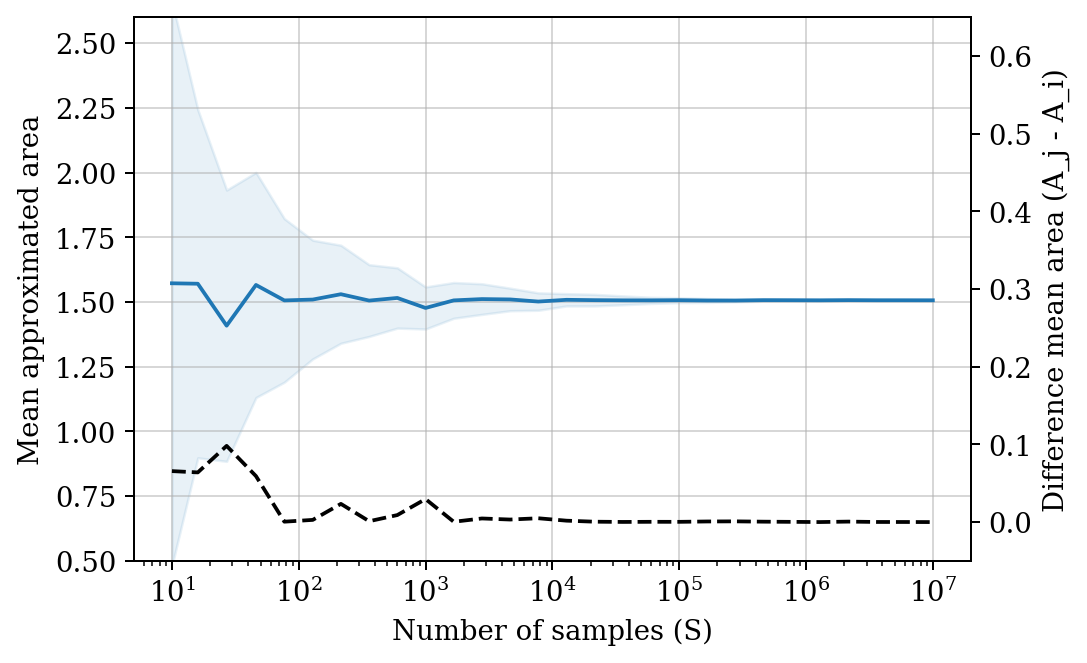

In [24]:
Plotter_S(Approx_areas_list_S_Uni, sample_size_range_S_Uni)

In [19]:
%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/I_iter")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e4), n_runs = 50, I_min_exp = 1, I_max_exp = 7)
#shelf["Approx_areas_list_I_Uni"] = Approx_areas_list_I_Uni
#shelf["iteration_range_I_Uni"] = iteration_range_I_Uni
#shelf.close()

Wall time: 22min 8s


In [20]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/I_iter")
Approx_areas_list_I_Uni = shelf["Approx_areas_list_I_Uni"]
iteration_range_I_Uni = shelf["iteration_range_I_Uni"]
shelf.close()

In [21]:
Approx_areas_list_array_I_Uni = np.array(Approx_areas_list_I_Uni)
Area_means_I_Uni = np.mean(Approx_areas_list_array_I_Uni, axis = 0)
Area_std_I_Uni = np.std(Approx_areas_list_array_I_Uni, axis = 0)
Error_I_Uni = np.abs(Area_means_I_Uni - Area_means_I_Uni[-1])

In [22]:
print("Means: ", Area_means_I_Uni)
print("Error: ", Error_I_Uni)
print("Std: ", Area_std_I_Uni)

Means:  [2.0984544  1.82099904 1.67067264 1.5977472  1.5547392  1.54363776
 1.52428416 1.51781952 1.51655616 1.50800832 1.50310272 1.50636864
 1.5101184  1.50765888 1.50525312 1.50384192 1.51087104 1.51201344
 1.50687936 1.50416448 1.5018528  1.50429888 1.50868032 1.50841152
 1.50691968 1.51208064 1.5101856  1.51210752]
Error:  [5.8634688e-01 3.0889152e-01 1.5856512e-01 8.5639680e-02 4.2631680e-02
 3.1530240e-02 1.2176640e-02 5.7120000e-03 4.4486400e-03 4.0992000e-03
 9.0048000e-03 5.7388800e-03 1.9891200e-03 4.4486400e-03 6.8544000e-03
 8.2656000e-03 1.2364800e-03 9.4080000e-05 5.2281600e-03 7.9430400e-03
 1.0254720e-02 7.8086400e-03 3.4272000e-03 3.6960000e-03 5.1878400e-03
 2.6880000e-05 1.9219200e-03 0.0000000e+00]
Std:  [0.0270332  0.02719822 0.02764221 0.02918337 0.0281365  0.02968836
 0.02808222 0.03420437 0.03319008 0.03426657 0.02804087 0.02708582
 0.02796812 0.02635653 0.02503088 0.03310117 0.02535229 0.02942086
 0.02534746 0.02652676 0.02538746 0.02734741 0.03010992 0.029854

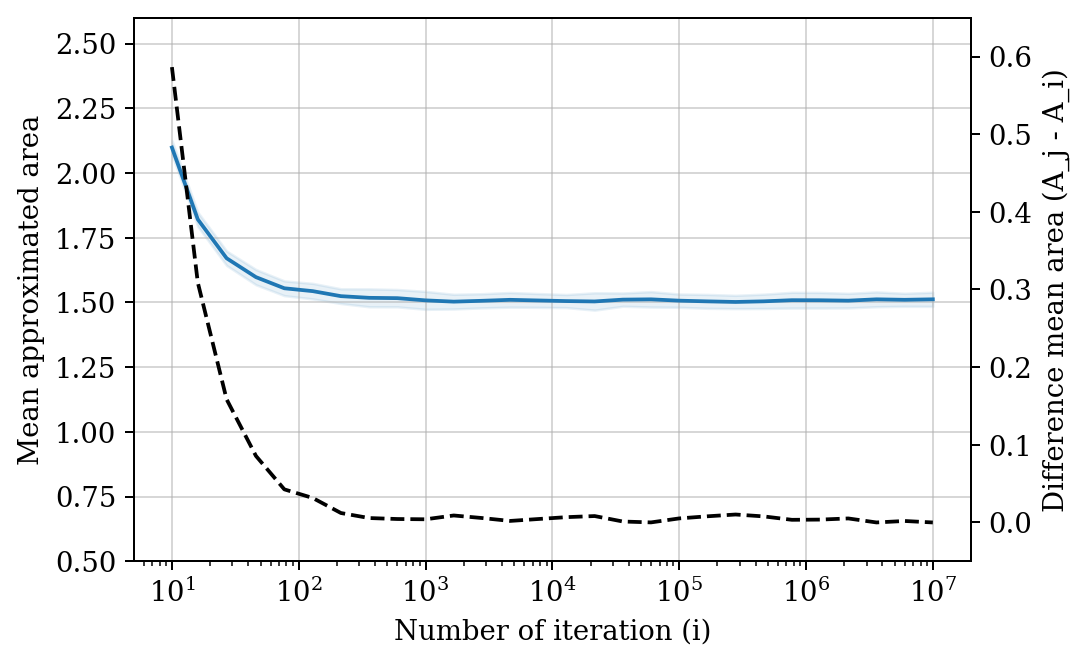

In [25]:
Plotter_I(Approx_areas_list_I_Uni, iteration_range_I_Uni)

### LHS Results ###

In [8]:
%%time
#shelf = shelve.open("Final_arrays_simulations/S_iter")
#Approx_areas_list_S_LHS, sample_size_range_S_LHS = S_iter(max_iter = int(1e4), n_runs = 50, S_min_exp = 1, S_max_exp = 7, sampling_method = latin_square_sampler)
#shelf["Approx_areas_list_S_LHS"] = Approx_areas_list_S_LHS
#shelf["sample_size_range_S_LHS"] = sample_size_range_S_LHS
#shelf.close()

In [9]:

# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/S_iter")
Approx_areas_list_S_LHS = shelf["Approx_areas_list_S_LHS"]
sample_size_range_S_LHS = shelf["sample_size_range_S_LHS"]
shelf.close()

Wall time: 13 ms


In [22]:
Statistics_print(Approx_areas_list_S_LHS, sample_size_range_S_LHS)

Means:  [1.66656    1.3608     1.50826667 1.45502609 1.53949091 1.50340465
 1.5284093  1.49786741 1.51564608 1.5098496  1.50934101 1.50985018
 1.50588235 1.50916166 1.50537366 1.50745845 1.50830323 1.5046666
 1.50696269 1.50653449 1.50681066 1.50659963 1.50665711 1.50661117
 1.50692686 1.50684163 1.50687295 1.50692137]
Error:  [1.59638627e-01 1.46121373e-01 1.34529323e-03 5.18952865e-02
 3.25695357e-02 3.51672228e-03 2.14879289e-02 9.05396397e-03
 8.72470335e-03 2.92822656e-03 2.41963375e-03 2.92880629e-03
 1.03902050e-03 2.24029021e-03 1.54771490e-03 5.37074388e-04
 1.38185991e-03 2.25476905e-03 4.13145600e-05 3.86887498e-04
 1.10714153e-04 3.21748312e-04 2.64258739e-04 3.10203132e-04
 5.48716469e-06 7.97466776e-05 4.84257960e-05 0.00000000e+00]
Confidence radius:  0.05127759195045818
Std:  [0.56370886 0.49156078 0.40355164 0.32325602 0.18639691 0.16202419
 0.10887012 0.10269986 0.08001327 0.0580215  0.0393457  0.03867128
 0.02933362 0.02035959 0.01605988 0.01108538 0.01017757 0.00635

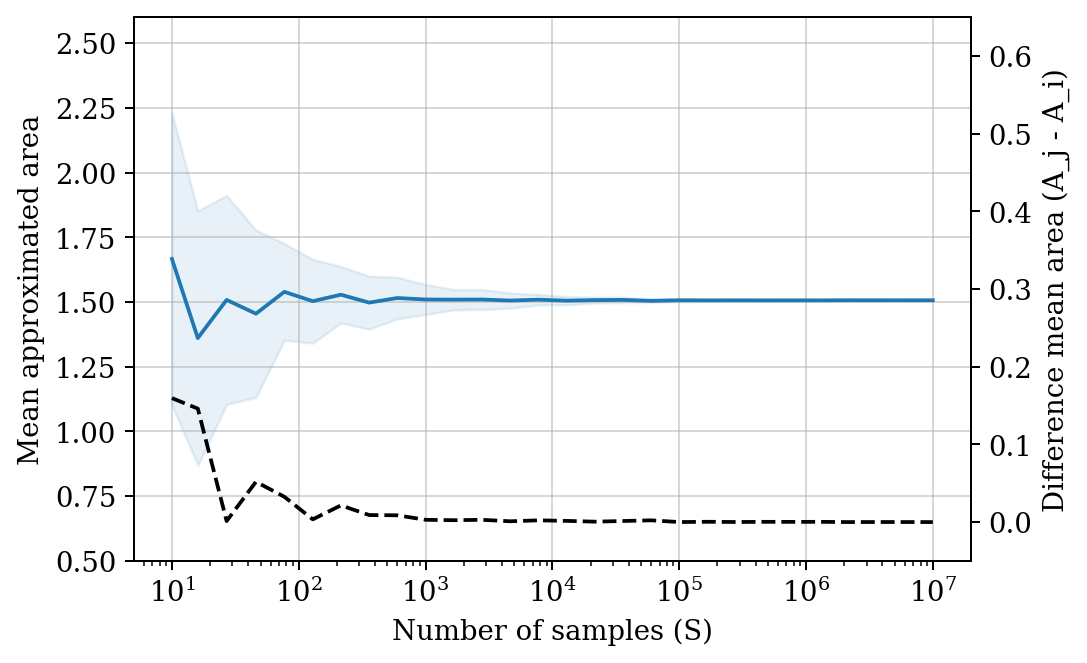

In [23]:
Plotter_S(Approx_areas_list_S_LHS, sample_size_range_S_LHS)

In [ ]:
%%time
# Generate and save objects
shelf = shelve.open("Final_arrays_simulations/I_iter")
Approx_areas_list_I_LHS, iteration_range_I_LHS = I_iter(sample_size = int(1e4), n_runs = 50, I_min_exp = 1, I_max_exp = 7, sampling_method = latin_square_sampler)
shelf["Approx_areas_list_I_LHS"] = Approx_areas_list_I_LHS
shelf["iteration_range_I_LHS"] = iteration_range_I_LHS
shelf.close()

In [33]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/I_iter")
Approx_areas_list_I_LHS = shelf["Approx_areas_list_I_LHS"]
iteration_range_I_LHS = shelf["iteration_range_I_LHS"]
shelf.close()


In [34]:
Statistics_print(Approx_areas_list_I_LHS, iteration_range_I_LHS)

Means:  [1.99823232 1.88727168 1.8032448  1.71815616 1.648752   1.59535488
 1.57270848 1.5545376 ]
Error:  [0.44369472 0.33273408 0.2487072  0.16361856 0.0942144  0.04081728
 0.01817088 0.        ]
Confidence radius:  0.05161229266454425
Std:  [0.13208045 0.15724725 0.16269879 0.12849967 0.07878357 0.05841345
 0.03525112 0.0250978 ]


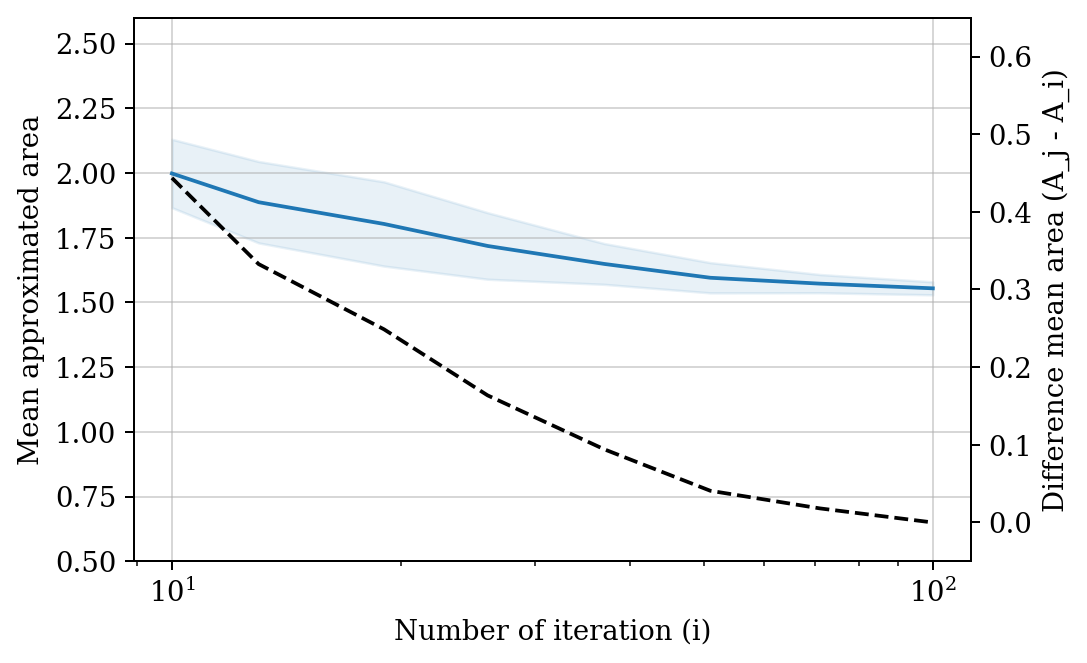

In [35]:
Plotter_I(Approx_areas_list_I_LHS, iteration_range_I_LHS)